#### Suplemental Material

## Morphing Projections: a new visual technique for fast and interactive large-scale analysis of biomedical datasets

Ignacio Díaz, José M. Enguita, Ana González, Diego García, Abel A. Cuadrado, María D. Chiara and Nuria Valdés

____

In [1]:
import os
import numpy as np
import pandas as pd
from time import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### 1 )  Source data: TCGA datasets

Download of gene expression, miRNA and clinical datasets.

In [2]:
# Path where the data will be stored
datapath = './data/'

# In case the folder does not exist
if not os.path.exists(datapath):
    os.mkdir(datapath)

#### 1. a ) Gene expression and miRNA datasets

Download of gene expression and miRNA datasets from [Xena Browser](https://xenabrowser.net/datapages/?hub=https://tcga.xenahubs.net:443).

In [3]:
# Types of cancer

cancer_list = ['ACC','CHOL','BLCA','BRCA','CESC','COAD','UCEC','ESCA','GBM','HNSC','KICH','KIRC','KIRP','DLBC',
               'LIHC','LGG','LUAD','LUSC','SKCM','MESO','UVM','OV','PAAD','PCPG','PRAD','READ','SARC','STAD',
               'TGCT','THYM','THCA','UCS']
    
cancer_list_long = ['Adrenocortical Cancer','Bile Duct Cancer','Bladder Cancer','Breast Cancer','Cervical Cancer',
                    'Colon Cancer','Endometrioid Cancer','Esophageal Cancer','Glioblastoma','Head and Neck Cancer',
                    'Kidney Chromophobe','Kidney Clear Cell Carcinoma','Kidney Papillary Cell Carcinoma',
                    'Large B-cell Lymphoma','Liver Cancer','Lower Grade Glioma','Lung Adenocarcinoma',
                    'Lung Squamous Cell Carcinoma','Melanoma','Mesothelioma','Ocular melanomas','Ovarian Cancer',
                    'Pancreatic Cancer','Pheochromocytoma & Paraganglioma','Prostate Cancer','Rectal Cancer',
                    'Sarcoma','Stomach Cancer','Testicular Cancer','Thymoma','Thyroid Cancer',
                    'Uterine Carcinosarcoma']

In [4]:
# Gene expression and miRNA datasets

if os.name=='nt':
    os.system('md '+ datapath.replace('/','\\'))
    os.system('md '+ datapath.replace('/','\\') + 'downloaded_data')
    
else:
    os.mkdir(datapath + 'downloaded_data')

for i in range (len(cancer_list)):
    
    print('downloading '+ cancer_list_long[i] +' ('+ cancer_list[i] +') data from xenabrowser ...')
    
    # gene expression
    os.system('wget https://tcga.xenahubs.net/download/TCGA.'+ cancer_list[i] + '.sampleMap/HiSeqV2_PANCAN.gz --no-check-certificate')
    os.system('gzip -d HiSeqV2_PANCAN.gz')
    if os.name=='nt':
        os.system('move HiSeqV2_PANCAN '+ datapath +'downloaded_data/'+ cancer_list[i] +'_gene_expression.csv')
    else:
        os.system('mv HiSeqV2_PANCAN '+ datapath +'downloaded_data/'+ cancer_list[i] +'_gene_expression.csv')
    
    # miRNA
    os.system('wget https://tcga.xenahubs.net/download/TCGA.'+ cancer_list[i] + '.sampleMap/miRNA_HiSeq_gene.gz --no-check-certificate')
    os.system('gzip -d miRNA_HiSeq_gene.gz')
    if os.name=='nt':
        os.system('move miRNA_HiSeq_gene '+ datapath +'downloaded_data/'+ cancer_list[i] +'_miRNA.csv')
    else:
        os.system('mv miRNA_HiSeq_gene '+ datapath +'downloaded_data/'+ cancer_list[i] +'_miRNA.csv')

print('downloads completed')

downloading Adrenocortical Cancer (ACC) data from xenabrowser ...
downloading Bile Duct Cancer (CHOL) data from xenabrowser ...
downloading Bladder Cancer (BLCA) data from xenabrowser ...
downloading Breast Cancer (BRCA) data from xenabrowser ...
downloading Cervical Cancer (CESC) data from xenabrowser ...
downloading Colon Cancer (COAD) data from xenabrowser ...
downloading Endometrioid Cancer (UCEC) data from xenabrowser ...
downloading Esophageal Cancer (ESCA) data from xenabrowser ...
downloading Glioblastoma (GBM) data from xenabrowser ...
downloading Head and Neck Cancer (HNSC) data from xenabrowser ...
downloading Kidney Chromophobe (KICH) data from xenabrowser ...
downloading Kidney Clear Cell Carcinoma (KIRC) data from xenabrowser ...
downloading Kidney Papillary Cell Carcinoma (KIRP) data from xenabrowser ...
downloading Large B-cell Lymphoma (DLBC) data from xenabrowser ...
downloading Liver Cancer (LIHC) data from xenabrowser ...
downloading Lower Grade Glioma (LGG) data fr

#### 1. b ) Clinical dataset

Manually download of clinical dataset from [GDC Data Portal](https://portal.gdc.cancer.gov/exploration?facetTab=clinical&filters=%7B%22op%22%3A%22and%22%2C%22content%22%3A%5B%7B%22op%22%3A%22in%22%2C%22content%22%3A%7B%22field%22%3A%22genes.is_cancer_gene_census%22%2C%22value%22%3A%5B%22true%22%5D%7D%7D%5D%7D):

- Click "Clinical" to download the dataset.
- Unzip the downloaded file.
- Move 'clinical.tsv' file to 'downloaded_data' directory.

 ____

### 2 )  Preprocessing of source data

Preprocessing of gene expression, miRNA and clinical datasets.

#### 2. a ) Gene expression and miRNA datasets

- Gene expression datasets: we remove rows containing the same value in all columns.
- miRNA datasets: we remove rows containing missing values.

Finally, we merge all datasets into one called 'df_data'.

In [5]:
print ('Preparing gene and miRNA data ...')

Preparing gene and miRNA data ...


In [6]:
genes_and_mirna = []

for i in range (len(cancer_list)):
    
    # gene expression
    # load csv and drop rows with repeated data
    data_genes = pd.read_csv(datapath +'downloaded_data/' + cancer_list[i] + '_gene_expression.csv',delim_whitespace=True)
    data_genes.set_index('sample', inplace=True)
    idx = np.where(data_genes.std(axis=1)<0.00001)[0]
    data_genes.drop(data_genes.index[idx],inplace=True)
    
    # miRNA
    # load csv and drop rows which contain missing values
    data_mirna = pd.read_csv(datapath +'downloaded_data/' + cancer_list[i] + '_miRNA.csv',delim_whitespace=True)
    data_mirna.set_index('sample', inplace=True)
    data_mirna.dropna(axis='index',inplace=True)
    
    # merge the two datasets: gene expression and miRNA
    data = data_genes.T.merge(data_mirna.T,how='inner',left_index=True,right_index=True)
    data['cancer']  = cancer_list[i]
    data['cancer#'] = i
    genes_and_mirna.append(data)

In [7]:
# concatenate genes and miRNAs dataframes
df_data = pd.concat(genes_and_mirna,sort=False).dropna(axis=1)
df_data['tumor'] = df_data.index

# miRNAs and genes present in the dataframe
list_mirna = [i for i in df_data.columns if 'MIMAT' in i]
list_genes = list(set([i for i in df_data.columns if 'MIMAT' not in i])-set(['cancer','cancer#','tumor']))

In [8]:
# homogenize type of tumor in a new variable called 'type'
df_data['type'] = 'other'
df_data.loc[df_data.index.str[-2:]=='01','type'] = 'primary'
df_data.loc[df_data.index.str[-2:]=='02','type'] = 'recurrent'
df_data.loc[(df_data.index.str[-2:]=='06')|(df_data.index.str[-2:]=='07'),'type'] = 'metastatic'
df_data.loc[(df_data.index.str[-2:]=='10')|(df_data.index.str[-2:]=='11'),'type'] = 'sane'

#### 2. b ) Clinical dataset

We remove duplicated rows, homogenize attributes and reduce the size of the dataset. The resulting dataset is called 'dfcl'.

In [9]:
print ('Preparing clinical data ...')

Preparing clinical data ...


In [10]:
# load csv and drop duplicated rows
dfcl = pd.read_csv(datapath +'downloaded_data/' + 'clinical.tsv',delimiter='\t')
dfcl.rename(columns={dfcl.columns[1]:'submitter_id'}, inplace=True)
dfcl.set_index('submitter_id',inplace=True)
dfcl = dfcl.loc[~dfcl.index.duplicated(keep='first')]

In [11]:
# homogenize metastases in a new variable called 'has_metastasis'
dfcl['has_metastasis'] = dfcl['ajcc_pathologic_m']
dfcl['has_metastasis'].replace(['M0'], 'no', inplace=True)
dfcl['has_metastasis'].replace(['M1','M1a','M1b','M1c'], 'yes', inplace=True)
dfcl['has_metastasis'].replace(['MX','cM0 (i+)'], '--', inplace=True)

In [12]:
# homogenize tumor stages
dfcl['tumor_stage'].replace(['stage ia','stage ib','is'], 'stage i', inplace=True)
dfcl['tumor_stage'].replace(['stage iia','stage iib','stage iic','i/ii nos'], 'stage ii', inplace=True)
dfcl['tumor_stage'].replace(['stage iiia','stage iiib','stage iiic'], 'stage iii', inplace=True)
dfcl['tumor_stage'].replace(['stage iva','stage ivb','stage ivc'], 'stage iv', inplace=True)
dfcl['tumor_stage'].replace(['x'], '--', inplace=True)

In [13]:
# reduce the size of the clinical dataset by considering only a few variables:
# list_cl_str (string type variables) and list_cl_num (numerical type variables)

list_cl_str = ['primary_diagnosis','prior_malignancy','site_of_resection_or_biopsy','treatment_type',
               'tumor_stage','morphology','ajcc_pathologic_m','ajcc_pathologic_n','ajcc_pathologic_stage',
               'ajcc_pathologic_t','race','gender','ethnicity','vital_status','has_metastasis']
list_cl_num = ['year_of_diagnosis','age_at_diagnosis','age_at_index']

dfcl        = dfcl[list_cl_str + list_cl_num]

In [14]:
# homogenize different words for "Unknown"
dfcl.replace(['not reported','Not Reported'], '--', inplace=True)

____

### 3 )  Final dataset

Merging of gene expression, miRNA and clinical datasets.

In [15]:
print ('Creating final dataset ...')

Creating final dataset ...


In [16]:
# before merging, modify df_data index to match dfcl index
df_data.index = ['-'.join(i.split('-')[:3]) for i in df_data.index]
df_data.index.name = 'submitter_id'

# merge the two datasets: df_data (gene expression and miRNA) and dfcl (clinical data)
df = df_data.merge(dfcl,how='inner',left_on='submitter_id',right_index=True)

In [17]:
# creation of a numerical variable for each categorical variable present in the final dataset
list_cl_strnum = []
list_cl_str.append('type')

for i in list_cl_str:
    clave = set(df[i])
    diccionario = dict(np.column_stack((list(sorted(clave)),np.array(range(len(clave))).astype(np.object)))) 
    df[i+'#'] = [diccionario[j] for j in df[i]]
    list_cl_strnum.append(i+'#')

# finally, we replace the numerical variable of "type#" for a better interpretability
df['type#'].replace([0,1,2,3,4], [2,4,0,1,3],inplace=True)

____

### 4 )  t-SNE

TCGA data projections by genes and miRNA using a t-SNE.

In [18]:
print ('Training t-SNEs ...')
print('starting time count ...')
t_init = time()

print('projection by genes')
tsne = TSNE(perplexity=20, learning_rate=200, n_iter=2000, n_components=2,method='barnes_hut',verbose=2, init='pca')
pr_genes = tsne.fit_transform(df[list_genes]) 
print('seconds: ',time()-t_init,'s')

print('projection by miRNA ...')
tsne = TSNE(perplexity=20, learning_rate=200, n_iter=2000, n_components=2,method='barnes_hut', verbose=2, init=pr_genes)
pr_mirna = tsne.fit_transform(df[list_mirna])
print('seconds: ',time()-t_init,'s')

Training t-SNEs ...
starting time count ...
projection by genes
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 8580 samples in 12.115s...
[t-SNE] Computed neighbors for 8580 samples in 2809.606s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8580
[t-SNE] Computed conditional probabilities for sample 2000 / 8580
[t-SNE] Computed conditional probabilities for sample 3000 / 8580
[t-SNE] Computed conditional probabilities for sample 4000 / 8580
[t-SNE] Computed conditional probabilities for sample 5000 / 8580
[t-SNE] Computed conditional probabilities for sample 6000 / 8580
[t-SNE] Computed conditional probabilities for sample 7000 / 8580
[t-SNE] Computed conditional probabilities for sample 8000 / 8580
[t-SNE] Computed conditional probabilities for sample 8580 / 8580
[t-SNE] Mean sigma: 41.209176
[t-SNE] Computed conditional probabilities in 0.236s
[t-SNE] Iteration 50: error = 67.6998978, gradient norm = 0.0363325 (50 iterations in 3.228s)
[t-SNE] Iteration 10

[t-SNE] Iteration 1350: error = 1.6053537, gradient norm = 0.0000558 (50 iterations in 2.688s)
[t-SNE] Iteration 1400: error = 1.6034288, gradient norm = 0.0000615 (50 iterations in 2.655s)
[t-SNE] Iteration 1450: error = 1.6011539, gradient norm = 0.0000858 (50 iterations in 2.698s)
[t-SNE] Iteration 1500: error = 1.5991927, gradient norm = 0.0000596 (50 iterations in 2.649s)
[t-SNE] Iteration 1550: error = 1.5970713, gradient norm = 0.0000617 (50 iterations in 2.677s)
[t-SNE] Iteration 1600: error = 1.5936751, gradient norm = 0.0000728 (50 iterations in 2.728s)
[t-SNE] Iteration 1650: error = 1.5900624, gradient norm = 0.0000726 (50 iterations in 2.692s)
[t-SNE] Iteration 1700: error = 1.5844134, gradient norm = 0.0000878 (50 iterations in 2.631s)
[t-SNE] Iteration 1750: error = 1.5772202, gradient norm = 0.0001252 (50 iterations in 2.625s)
[t-SNE] Iteration 1800: error = 1.5753355, gradient norm = 0.0000522 (50 iterations in 2.613s)
[t-SNE] Iteration 1850: error = 1.5739393, gradien

In [19]:
# creation of the dataframe 'df_morphing'
# containing the projections obtained with the t-SNE

df_morphing = pd.DataFrame()
df_morphing['genes_x'] = pr_genes[:,0]
df_morphing['genes_y'] = pr_genes[:,1]
df_morphing['mirna_x'] = pr_mirna[:,0]
df_morphing['mirna_y'] = pr_mirna[:,1]
df_morphing['tumor'] = df.index
df_morphing.set_index('tumor', inplace=True)  

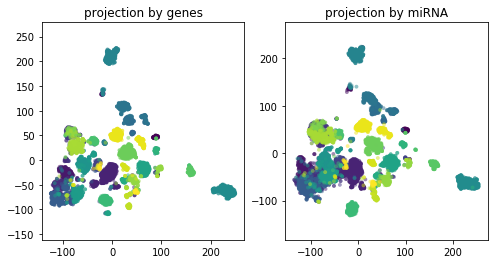

In [20]:
# visualization of projections

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(df_morphing['genes_x'],df_morphing['genes_y'],c=df['cancer#'],s=15,alpha=0.5,linewidths=0)
plt.title('projection by genes')
plt.axis('equal')
plt.subplot(1,2,2)
plt.scatter(df_morphing['mirna_x'],df_morphing['mirna_y'],c=df['cancer#'],s=15,alpha=0.5,linewidths=0)
plt.title('projection by miRNA')
plt.axis('equal')
plt.show()

____

### 5 )  Save results

In [21]:
if os.name=='nt':
    os.system('md '+ datapath.replace('/','\\'))
    os.system('md '+ datapath.replace('/','\\') + 'temp')
else:
    os.mkdir(datapath + 'temp')

print ('Saving results ...') 
df.to_hdf(datapath + 'temp/pancancer_with_metadata.hdf', key='raiz')
df_morphing.to_hdf(datapath + 'temp/pancancer_morphing.hdf', key='raiz')
df_data.to_hdf(datapath + 'temp/df_data.hdf', key='raiz')
print ('Finished.')

Saving results ...
Finished.
